In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from data_utils.dataset import ChangeDetectionDataset
from utils.main import FCSiamDiff, FCEF


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8

train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

train_dataset = ChangeDetectionDataset(val_dir, transforms)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataset = ChangeDetectionDataset(val_dir, transforms)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True
)

test_dataset = ChangeDetectionDataset(val_dir, transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

lr = 3e-4
num_epoches = 50

net = FCEF().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr)

loss_func = nn.BCEWithLogitsLoss()




In [2]:
l_his = []

for epoch in range(num_epoches):
    print("Epoch:", epoch + 1, "Training...")
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)

        x, labels = (
            Variable(x),
            Variable(labels.float()),
        )

        optimizer.zero_grad()
        f1 = net(x)
        # print(f1.size(), labels.size())
        loss = loss_func(f1, labels)
        loss.backward()
        optimizer.step()
        if i % 5 == 4:
            l_his.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

Epoch: 1 Training...
[1,    50] loss: 0.293
[1,   100] loss: 0.260
Epoch: 2 Training...
[2,    50] loss: 0.245
[2,   100] loss: 0.238
Epoch: 3 Training...
[3,    50] loss: 0.229
[3,   100] loss: 0.224
Epoch: 4 Training...
[4,    50] loss: 0.216
[4,   100] loss: 0.211
Epoch: 5 Training...
[5,    50] loss: 0.203
[5,   100] loss: 0.199
Epoch: 6 Training...
[6,    50] loss: 0.191
[6,   100] loss: 0.187
Epoch: 7 Training...
[7,    50] loss: 0.180
[7,   100] loss: 0.175
Epoch: 8 Training...
[8,    50] loss: 0.168
[8,   100] loss: 0.164
Epoch: 9 Training...
[9,    50] loss: 0.157
[9,   100] loss: 0.153
Epoch: 10 Training...
[10,    50] loss: 0.147
[10,   100] loss: 0.143
Epoch: 11 Training...
[11,    50] loss: 0.138
[11,   100] loss: 0.134
Epoch: 12 Training...
[12,    50] loss: 0.129
[12,   100] loss: 0.125
Epoch: 13 Training...
[13,    50] loss: 0.120
[13,   100] loss: 0.117
Epoch: 14 Training...
[14,    50] loss: 0.113
[14,   100] loss: 0.110
Epoch: 15 Training...
[15,    50] loss: 0.106
[

Finished Training


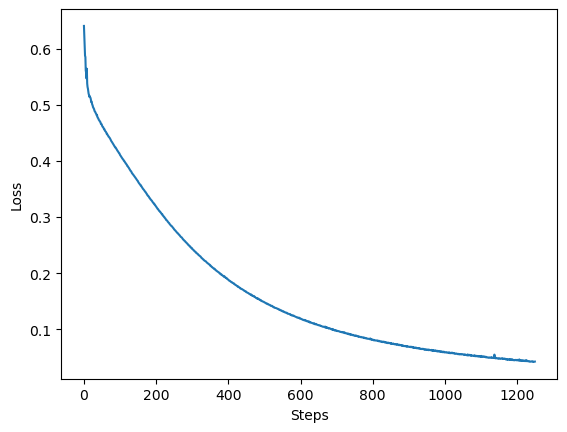

In [3]:

print("Finished Training")
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(l_his)
plt.xlabel("Steps")
plt.ylabel("Loss")
fig.savefig("plott2.png")

In [4]:
# net = net.to("gpu")

for i, data in enumerate(val_dataloader, 0):

        x, labels = data["x"], data["mask"]

        x = x.to(device)
        labels = labels.to(device)

        x, labels = (
            Variable(x),
            Variable(labels.float()),
        )
        with torch.no_grad():
            f1 = net(x).cpu().detach().numpy()

        # print()
        for i in range(4):
            plt.figure()
            plt.imshow(f1[i][0])
        input()